In [1]:
# Import Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
# from joblib import dump

In [2]:
# Call in the data
df = pd.read_csv('Resources/sales.csv')
df.head()

,Date,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,weekly_sales,year,month,day,week_of_year,promotion
0,05-02-2010,1,1,False,9.99,7.99,245,1957.55,2010,2,5,5,1
1,12-02-2010,1,1,True,9.99,7.99,453,3619.47,2010,2,12,6,1
2,19-02-2010,1,1,False,9.99,7.99,409,3267.91,2010,2,19,7,1
3,26-02-2010,1,1,False,9.99,7.99,191,1526.09,2010,2,26,8,1
4,05-03-2010,1,1,False,9.99,9.99,145,1448.55,2010,3,5,9,0


In [3]:
# We don't need Date, year, day, or month and weekly_sales is calculated using the weekly units sold which would make our model 'leaky'.
df=df.drop(columns=['Date', 'year', 'day', 'month','weekly_sales'])
df.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,week_of_year,promotion
0,1,1,False,9.99,7.99,245,5,1
1,1,1,True,9.99,7.99,453,6,1
2,1,1,False,9.99,7.99,409,7,1
3,1,1,False,9.99,7.99,191,8,1
4,1,1,False,9.99,9.99,145,9,0


In [4]:
# Reordering so the data reads a little better. 
df=df[['Store','Product','week_of_year','Base Price','Price','promotion','Is_Holiday','Weekly_Units_Sold']]
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,1,1,5,9.99,7.99,1,False,245
1,1,1,6,9.99,7.99,1,True,453
2,1,1,7,9.99,7.99,1,False,409
3,1,1,8,9.99,7.99,1,False,191
4,1,1,9,9.99,9.99,0,False,145


In [5]:
# We want to one-hot encode Store, Product, and Week of the Year because 
# Store and Product are not ordinal as they appear to be and also shouldn't really be
# numeric data. The numbers are just place holders. 
df['Temp']='_'
df['Store'] = df['Temp'].str.cat(df['Store'].values.astype(str))
df['Product'] = df['Temp'].str.cat(df['Product'].values.astype(str))
df['week_of_year'] = df['Temp'].str.cat(df['week_of_year'].values.astype(str))
del df['Temp']
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,False,245
1,_1,_1,_6,9.99,7.99,1,True,453
2,_1,_1,_7,9.99,7.99,1,False,409
3,_1,_1,_8,9.99,7.99,1,False,191
4,_1,_1,_9,9.99,9.99,0,False,145


In [6]:
#  LabelEncoding Is_Holiday column
df['Is_Holiday']=LabelEncoder().fit_transform(df['Is_Holiday'])
df.head()

,Store,Product,week_of_year,Base Price,Price,promotion,Is_Holiday,Weekly_Units_Sold
0,_1,_1,_5,9.99,7.99,1,0,245
1,_1,_1,_6,9.99,7.99,1,1,453
2,_1,_1,_7,9.99,7.99,1,0,409
3,_1,_1,_8,9.99,7.99,1,0,191
4,_1,_1,_9,9.99,9.99,0,0,145


In [7]:
# The final use CSV
df.to_csv("Resources/preprocessed.csv")

In [8]:
#  Setting up DF for the products so we can check models individually if necessary. 
pro1=df[df['Product']=='_1']
pro2=df[df['Product']=='_2']
pro3=df[df['Product']=='_3']

In [9]:
# Create features
X=df.drop(columns=['Weekly_Units_Sold'], axis = 1)

# One-Hot encode the DF. 
X=pd.get_dummies(X)

# Create target. 
y = df['Weekly_Units_Sold']

In [10]:
# Feature DF. 
X

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
0,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,9.99,7.99,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9.99,7.99,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,9.99,9.99,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3856,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3857,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3858,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3859,19.99,19.99,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
X.to_csv("Resources/encoded_features.csv")

In [12]:
y

0       245
1       453
2       409
3       191
4       145
       ... 
3856    133
3857    133
3858    127
3859    133
3860    136
Name: Weekly_Units_Sold, Length: 3861, dtype: int64

In [13]:
# Looking at the feature DF. 
X.describe()

,Base Price,Price,promotion,Is_Holiday,Store__1,Store__10,Store__2,Store__3,Store__4,Store__5,...,week_of_year__48,week_of_year__49,week_of_year__5,week_of_year__50,week_of_year__51,week_of_year__52,week_of_year__6,week_of_year__7,week_of_year__8,week_of_year__9
count,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,...,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000,3861.000000
mean,12.554103,11.766084,0.172494,0.069930,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,...,0.013986,0.013986,0.020979,0.013986,0.013986,0.013986,0.020979,0.020979,0.020979,0.020979
std,6.079043,5.976196,0.377858,0.255062,0.314310,0.314310,0.314310,0.314310,0.314310,0.314310,...,0.117448,0.117448,0.143333,0.117448,0.117448,0.117448,0.143333,0.143333,0.143333,0.143333
min,5.990000,4.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.990000,5.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.990000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,19.990000,19.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.990000,21.990000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Linear Regression

In [14]:
#finds the best fit linear line between the independent and dependent variable i.e it finds the linear relationship between the dependent and independent variable.

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Create and train the model
model = LinearRegression().fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)


In [16]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.6942837034157782
Testing Score: 0.6416047756318379
---------------------
R2 Score: 0.6416047756318379


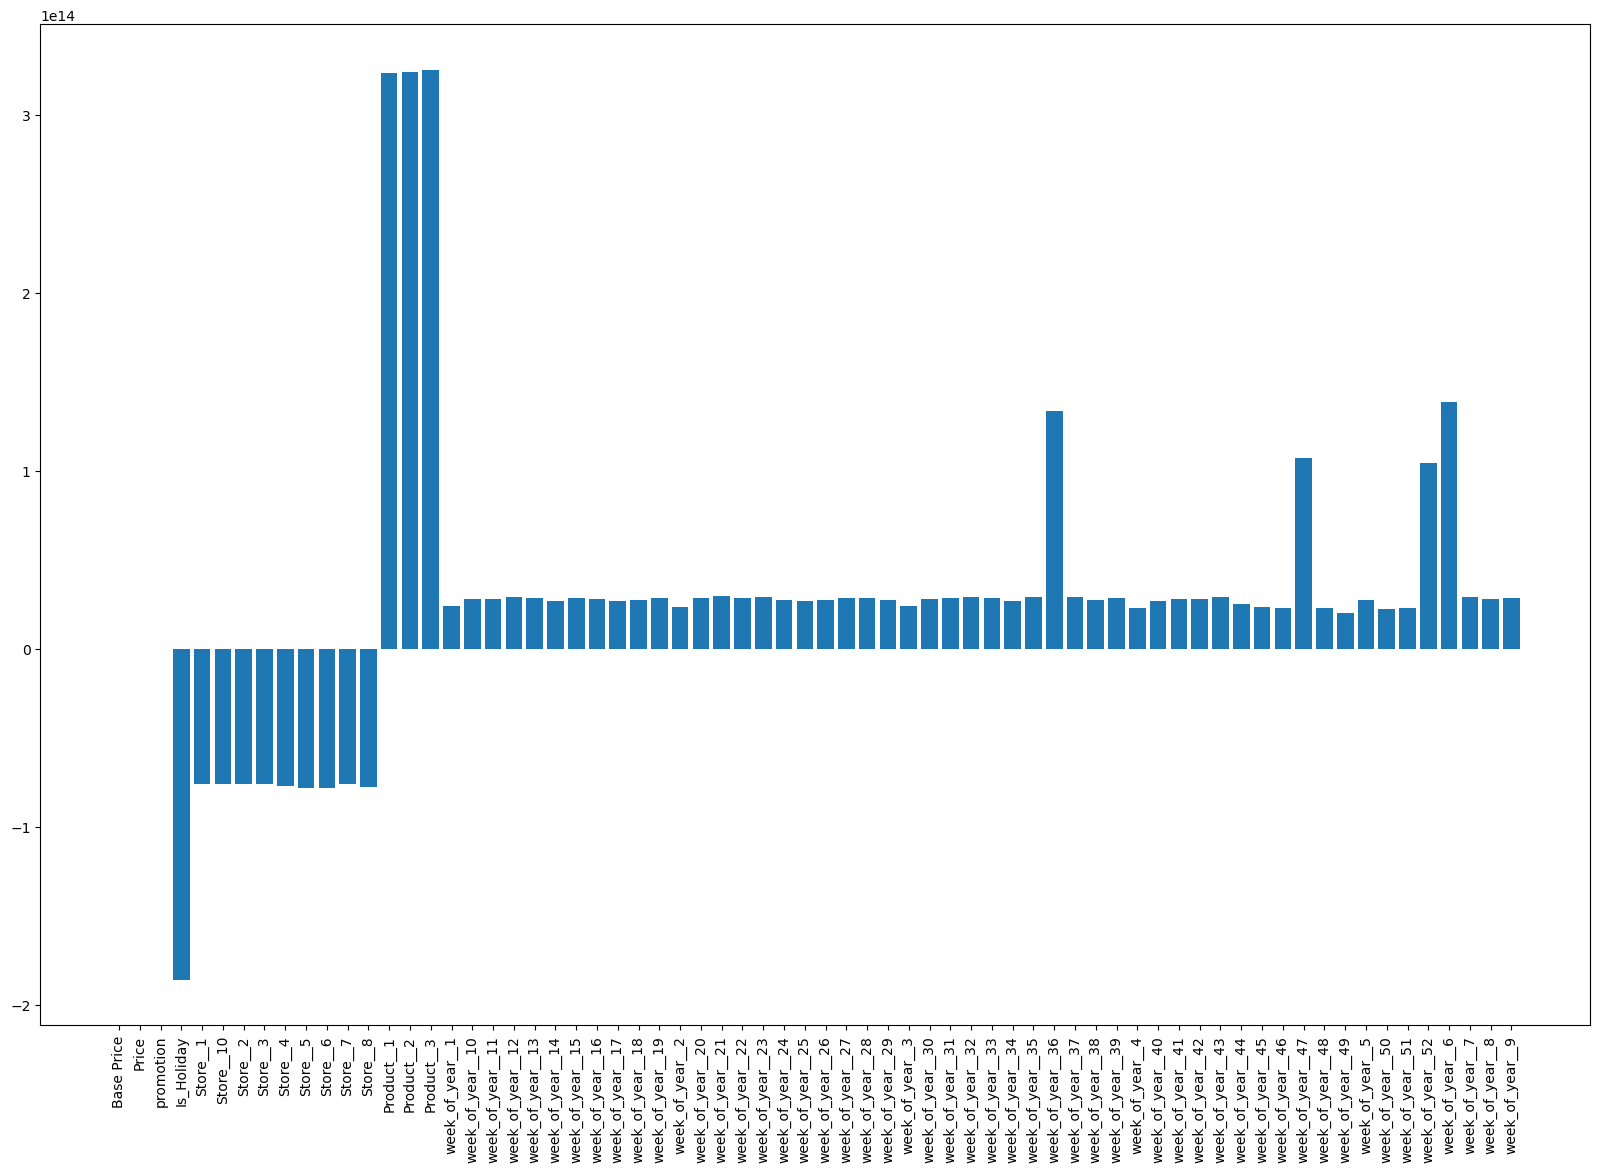

In [17]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_,)
plt.show()

## Lasso Regression 

In [18]:
#least absolute shrinkage and selection operator
#The lasso regression allows you to shrink or regularize these coefficients to avoid overfitting and make them work better on different datasets.

# Create and train the model
model = Lasso(max_iter=10000).fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)


In [19]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.692694529446761
Testing Score: 0.6409196007948497
---------------------
R2 Score: 0.6409196007948497


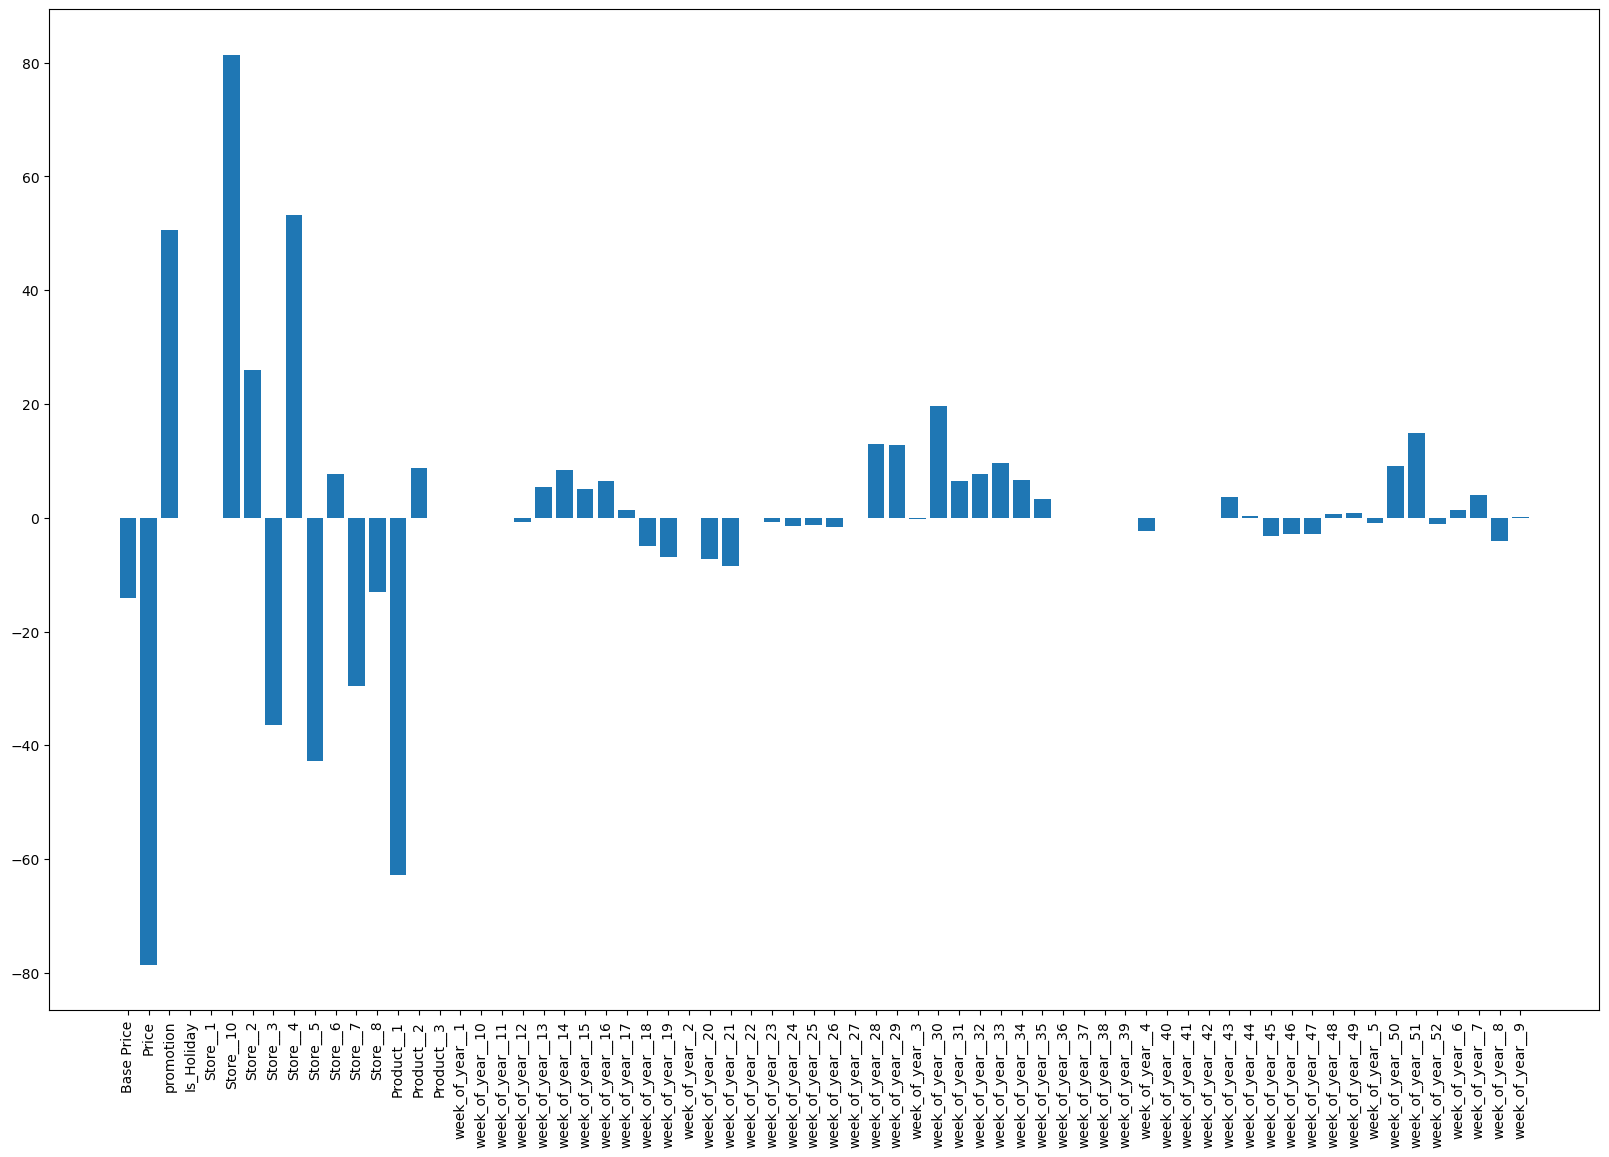

In [20]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_)
plt.show()

## Ridge

In [21]:
#Ridge regression is a model tuning method that is used to analyse any data that suffers from multicollinearity.
# When the issue of multicollinearity occurs, least-squares are unbiased, and variances are large, this results in predicted values being far away from the actual values.

# Create and train the model
model = Ridge(alpha=100).fit(X_train_scaled, y_train)

# Generate predictions
y_pred = model.predict(X_test_scaled)

In [22]:
#  Score Data
training_score = model.score(X_train_scaled, y_train)
testing_score = model.score(X_test_scaled, y_test)

score = r2_score(y_test, y_pred)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.692774906219298
Testing Score: 0.6384478239268325
---------------------
R2 Score: 0.6384478239268325


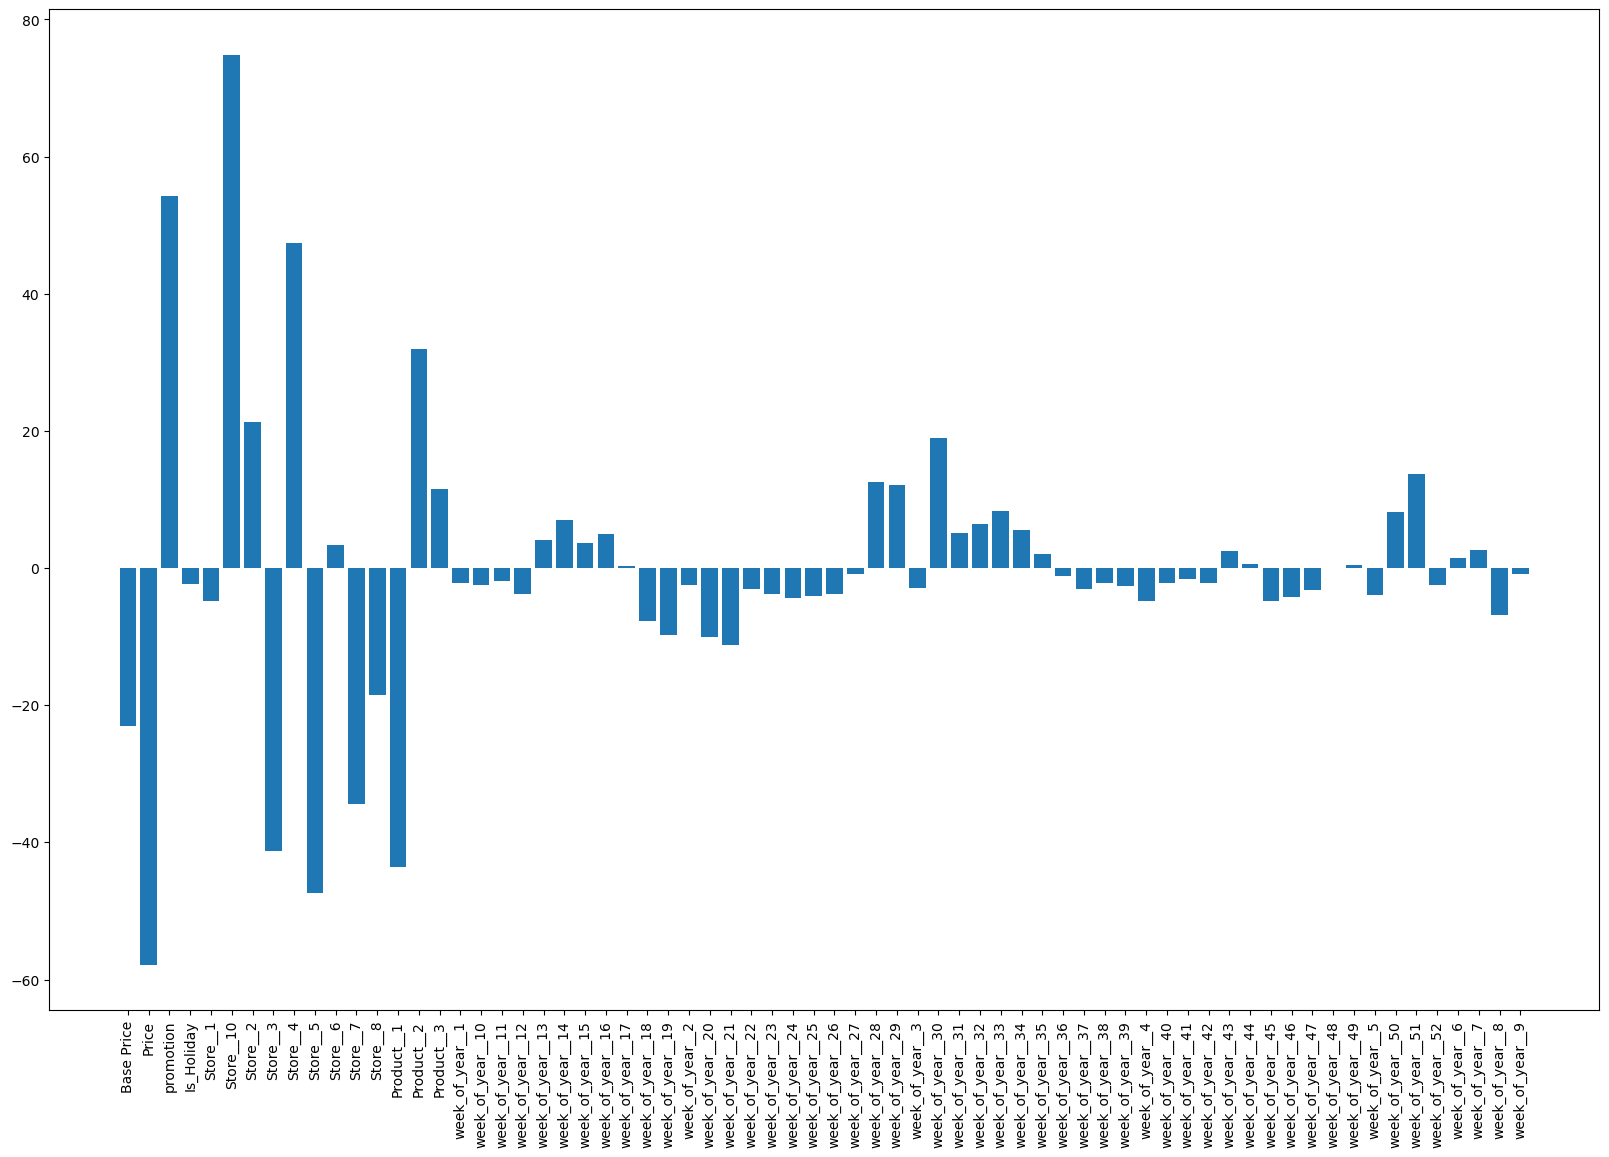

In [23]:
# Visualizing the regression coefficients. 
plt.rcParams["figure.figsize"] = (20,13)
plt.xticks(rotation=90)
plt.bar(X_train.columns, model.coef_)
plt.show()

## Bayesian Ridge Regression

In [43]:
# from sklearn.linear_model import BayesianRidge

#Bayesian regression allows a natural mechanism to survive insufficient data or poorly distributed data by formulating linear regression using probability distributors rather than point estimates.

In [44]:
model=BayesianRidge()
model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.6937402106121953
0.6403766781158824
93.5075025000732
0.6403766781158824


## Gradient Boosting Regression

In [46]:
# from sklearn.ensemble import GradientBoostingRegressor

In [47]:
model=GradientBoostingRegressor()
model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

0.9064970401172487
0.8292371497057784
43.878642978058686
0.8292371497057784


In [48]:
# dump(model, 'filename.joblib') 

## Support Vector Machine

In [49]:
# from sklearn.svm import SVR

#SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable.

In [50]:
model=SVR()
model.fit(X_train_scaled, y_train)
pred=model.predict(X_test_scaled)

# for classification we use accuracy and F1 score
print(model.score(X_train_scaled,y_train))
print(model.score(X_test_scaled, y_test))


# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above

print(mean_absolute_error(y_test,pred))
print(r2_score(y_test,pred))

-0.017098341823124308
-0.02954205174891089
133.4929755046794
-0.02954205174891089


## Polynomial Features

In [51]:
# add higher order polynomial features to linear regression
# create instance of polynomial regression class
model = PolynomialFeatures(degree=1)
# create new training data with polynomial features instance
X_train_poly = model.fit_transform(X_train)
# fit with features using linear model
poly_fit = LinearRegression().fit(X_train_poly, y_train)
# check how polynomial (2nd order) model works on train data
training_score =poly_fit.score(X_train_poly, y_train)

# transform test data with poly instance-
# DO NOT fit_transform
X_test_poly = model.transform(X_test)
# check how polynomial (7th order) model works on train data
testing_score = poly_fit.score(X_test_poly, y_test)

score = r2_score(y_test, y_pred)

In [52]:
print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print('---------------------')
print(f"R2 Score: {score}")

Training Score: 0.694288933355492
Testing Score: 0.641618631035264
---------------------
R2 Score: 0.24072620257201416
